## TODO
class vehicule movement predictor
put vehicule to x0,y0,a0 and rotate all the points
receive vehicule north and host point


In [1]:
print('test')

test


## Cameras

In [1]:
from src.vision import Camera

mba_video_camera = Camera(
    h_fov=59.0,
    h_res=1080,
    v_res=720,
)

mba_photo_camera = Camera(
    h_fov=67.0,
    h_res=1290,
    v_res=720,
)

zed_two_camera = Camera(
    h_fov=110.0,
    v_fov=70.0,
)

avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [2]:
from src.point import Point

ref_points = [
    Point(0, 0),
    Point(1200, 0),
    Point(2200, 0),
    Point(4200, 0),
    Point(3000, 1280),
    Point(3995, 1590),
    Point(3005, -1150),
    Point(4000, -1490),
]
print(ref_points)


[Point(x=0, y=0, a=None), Point(x=1200, y=0, a=None), Point(x=2200, y=0, a=None), Point(x=4200, y=0, a=None), Point(x=3000, y=1280, a=None), Point(x=3995, y=1590, a=None), Point(x=3005, y=-1150, a=None), Point(x=4000, y=-1490, a=None)]


In [3]:
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import cv2
import math
import time

import torch


## YOLOv8 For human and objects detection

First attempt at human positioning with YOLOv8. Unsure if will be usefull because of the RGBD camera. It lets us estimates the angle between the camera and the person. Could also be usefull for object detection and avoidance. 

In [13]:
from ultralytics import YOLO


def get_objs(res):
    columns=['xmin', 'ymin', 'xmax', 'ymax', 'xcenter', 'score', 'class', 'name']
    df = pd.DataFrame(columns=columns)
    for r in res:
        for i in range(len(r.boxes.cls)):
            xyxy = np.array(r.boxes.xyxy[i].cpu(), dtype=int)
            df = pd.concat([df, pd.DataFrame({
                    'xmin': xyxy[0],
                    'ymin': xyxy[1],
                    'xmax': xyxy[2],
                    'ymax': xyxy[3],
                    'xcenter': int((xyxy[0] + xyxy[2]) / 2),
                    'score': float(r.boxes.conf[i]),
                    'class': int(r.boxes.cls[i]),
                    'name': names[int(r.boxes.cls[i])]
                }, index=[0])],
            ) 
    return df


yolo_model = YOLO('yolov8s.pt')

try:
    # Initiate the camera
    prev_angle = 0.0
    # vid = cv2.VideoCapture(0)
    vid = cv2.VideoCapture('./Movie on 2023-11-23 at 10.03.mov')
    time.sleep(0.5)

    while True:
        frame = grab_frame(vid)
        skip_frames(vid, 14)
        res = yolo_model(frame, verbose=False)
        objs = get_objs(res)

        clear_output(wait=True)

        fig, ax = plt.subplots()
        ax.imshow(frame)

        for index, obj in objs.iterrows():
            if obj['class'] != 0: continue
            if obj['score'] < 0.4: continue
            on_edge = obj['xmin'] < 10 or obj['xmax'] > wr - 10
            color = 'r' if on_edge else 'g'

            rect = patches.Rectangle((obj['xmin'], obj['ymin']), obj['xmax'] - obj['xmin'], obj['ymax'] - obj['ymin'], linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            text = f'{obj["name"]} {obj["score"]:.2f}'
            ax.text(obj['xmin'], obj['ymin'], text, color='b', fontsize=12)

            # draw vertical line at xcenter
            center_df = obj['xcenter']
            if on_edge:
                center_df = obj['xcenter'] // 2 if center_df < wr / 2 else (center_df + wr) // 2
            # angle_deg = (center - wr / 2) * hfov / wr
            angle_deg = pixel_angle(hfov, wr, center_df)
            ax.plot([center_df, center_df], [obj['ymin'], obj['ymax']], color='c', linewidth=2)
            ax.text(center_df, obj['ymin'], f'{angle_deg:.2f} deg', color='c', fontsize=12)

            mov_angle = angle_deg - prev_angle
            prev_angle = angle_deg

        plt.axis('off')
        plt.show()
        print(f' {mov_angle:.2f} deg')

        # save angle to csv with pandas - angle_deg and mov_angle
        # todo need to isolate one person only
        # todo add new on firts line
        pd.DataFrame({
            'a': [round(angle_deg, 2)],
            'da': [round(mov_angle, 2)]
        }).to_csv('var.csv', index=False, mode='a', header=False)
        
        # Frame rate
        # plt.pause(0.15)
        # break

except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break

[ WARN:0@490.902] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@490.902] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin4 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@490.902] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@490.902] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/video

NameError: name 'names' is not defined

## MediPipe Pose landmark detection

This model lets us estimate a skeleton of a human. By using the average human torso height which is invariant to rotation when the person is walking, it is possible to estimate the distance and the angle of the person in relation to the camera. 

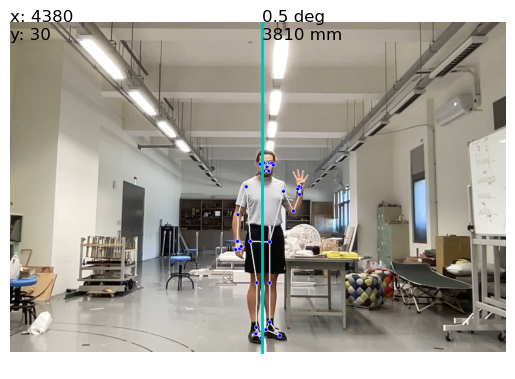

In [7]:
from src.vision import PositionEstimator, VideoCapture
import mediapipe as mp


try:
    cap = VideoCapture('./Movie on 2023-11-23 at 10.03.mov')
    # cap = VideoCapture(0)

    camera = mba_video_camera
    pe = PositionEstimator(
        mp.solutions.pose, 
        camera,
        avg_torso_height, 
        queue_size=3,
        kernel_size=3
    )

    while cap.isOpened():
        clear_output(wait=True)
        frame = cap.grab_frame()
        if frame is None: break
        cap.skip_frames(14) # skip 14 frames - for 2 images per second
        # plt.pause(0.15) # to set frame rate in realtime-ish

        results, point, distance, angle = pe.save_position(
            frame, 
            file_path='var.csv',
            adjustment_ratio=1.15, 
            verbose=True
        )
        if results is None: continue

        pixel_angle = camera.angle_to_pixel(angle)
        fig, ax = plt.subplots()
        ax.imshow(frame)
        if results.pose_landmarks is not None:
            ax.plot([pixel_angle, pixel_angle], [0, frame.shape[0]], color='c', linewidth=2)
            ax.text(pixel_angle, 0, f'{angle:.1f} deg', color='k', fontsize=12)
            ax.text(pixel_angle, 40, f'{distance} mm', color='k', fontsize=12)
            ax.text(0, 0, f'x: {point.x}', color='k', fontsize=12)
            ax.text(0, 40, f'y: {point.y}', color='k', fontsize=12)
        plt.axis('off')
        plt.show()

except KeyboardInterrupt:
    cap.release()
    pass  # Release the camera resource

cap.release()  # Release the camera resource if break


## Sampled points from spline
Whith the data from the skeleton (angle and distance), it is possible to calculate the coordinates of the person with great accuracy. The red dots represents the reference ground markers used when recording the video. A spline can be calculated to smooth the data which should be done in real time with the new data that is coming in. 

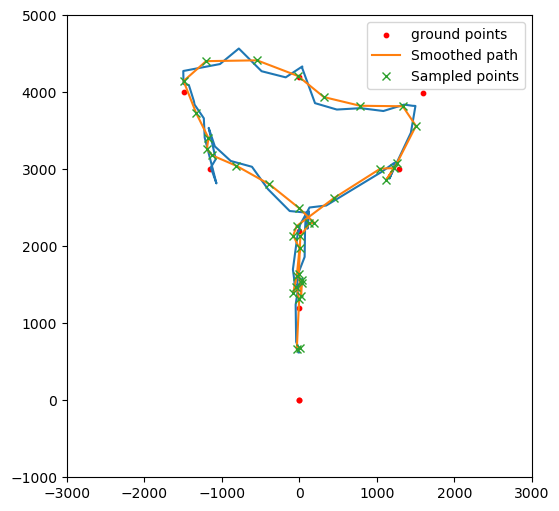

In [202]:
from scipy import interpolate
from scipy.interpolate import splrep, BSpline, splprep

# read csv
df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd'] # time angle distance

# add column x and y
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))



# fig, ax = plt.subplots()
# ax.plot(df['y'], df['x'])
# for p in points:
#     ax.scatter(p.y, p.x, c='r', s=10)
# plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

# Assuming df is your DataFrame with 'x' and 'y' columns
# df = pd.read_csv('your_data.csv')  # Uncomment this line if you need to load data from a CSV file

ti = df.index

# Set the number of knots. Adjust this according to your data
# num_knots = 10
num_knots = int((ti.max() - ti.min()) // 4)
t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]  # Exclude first and last points

# Fit the spline for 'x' and 'y' coordinates
spline_x = LSQUnivariateSpline(ti, df['x'], t_knots)
spline_y = LSQUnivariateSpline(ti, df['y'], t_knots)

num_samples = num_knots * 2
t_smooth = np.linspace(ti.min(), ti.max(), num_samples)

# Evaluate the spline at these points
x_sampled = spline_x(t_smooth)
y_sampled = spline_y(t_smooth)

# Create a DataFrame with the sampled data
sampled_df = pd.DataFrame({
    't': t_smooth,
    'x': x_sampled,
    'y': y_sampled
})

fig, ax = plt.subplots()
ax.set_ylim([-1000, 5000])
ax.set_xlim([-3000, 3000])
fig.set_figheight(6)
fig.set_figwidth(6)

ax.plot(df['y'], df['x'])
for p in ref_points:
    ax.scatter(p.y, p.x, c='r', s=10)
ax.scatter(ref_points[0].y, ref_points[0].x, c='r', s=10, label='ground points')
ax.plot(spline_y(t_smooth), spline_x(t_smooth), label='Smoothed path')
# ax.plot(spline_y(t_smooth), spline_x(t_smooth))
ax.plot(spline_y(t_smooth), spline_x(t_smooth), 'x', label='Sampled points')
ax.legend()
plt.show()


# x = spline_x(t_smooth)
# y = spline_y(t_smooth)



# for i in range(len(x) - 4):
#     # angle between i-1 and i
#     if i == 0:
#         p1 = Point(0, 0)
#     else:
#         p1 = Point(x[i-1], y[i-1])
#     p2 = Point(x[i], y[i])

#     angle = p1.angle(p2)

#     # list of 4 points with list comprehension
#     px = [Point(x[i], y[i]) for i in range(i, i+4)]

#     # rotate 4 points by -angle around p2
#     px = [p.rotate_df(-angle, p2) for p in px]

#     clear_output(wait=True)
#     fig, ax = plt.subplots()
#     px_x = [p.x for p in px]
#     px_y = [p.y for p in px]
#     ax.plot(px_y, px_x)
    
#     ax.legend()
#     plt.show()
#     plt.pause(0.5)



## Uniformly sampled points from spline

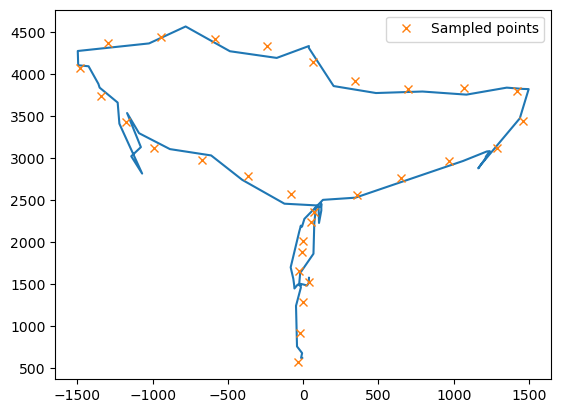

In [36]:
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd']
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))

ti = np.array(df.index, dtype=float)
df['t'] = df['t'].astype(float)

# Define the spline
num_knots = int((ti.max() - ti.min()) // 4)
t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]  # Exclude first and last points
spline_x = LSQUnivariateSpline(ti, df['x'], t_knots)
spline_y = LSQUnivariateSpline(ti, df['y'], t_knots)

# Initialize variables for sampling
min_distance = 350
sampled_points = []
last_point = None

# Iterate over the spline
for ti in np.linspace(ti.min(), ti.max(), 1000):  # Adjust the number of points as necessary
    current_point = Point(spline_x(ti), spline_y(ti), 0)  # Assuming z=0 as it's not in the DataFrame

    if last_point is None:
        # First point
        sampled_points.append(current_point)
        last_point = current_point
    else:
        # Check distance
        if current_point.distance(last_point) >= min_distance:
            sampled_points.append(current_point)
            last_point = current_point

# Convert sampled points to a DataFrame
sampled_df = pd.DataFrame([(p.x, p.y) for p in sampled_points], columns=['x', 'y'])


# spline_timestamp = LSQUnivariateSpline(ti, df['t'], t_knots)
# sampled_timestamps = spline_timestamp([p.t for p in sampled_points])
# sampled_df['timestamp'] = sampled_timestamps


# sampled_df['dd'] = 0
# for i in range(1, len(sampled_df['x'])):
#     p1 = Point(sampled_df['x'][i-1], sampled_df['y'][i-1], 0)
#     p2 = Point(sampled_df['x'][i], sampled_df['y'][i], 0)
#     sampled_df['dd'][i] = p1.distance(p2)


# # add column td which is the sum of the previous td and its dd
# sampled_df['td'] = 0
# for i in range(1, len(sampled_df['x'])):
#     p1 = Point(sampled_df['x'][i-1], sampled_df['y'][i-1], 0)
#     p2 = Point(sampled_df['x'][i], sampled_df['y'][i], 0)
#     sampled_df['td'][i] = sampled_df['td'][i-1] + p1.distance(p2)


# # print the whole values of sampled_df['timestamp']
# for i in range(len(sampled_df['timestamp'])):
#     print(sampled_df['timestamp'][i])


# Plot to verify
fig, ax = plt.subplots()
ax.plot(df['y'], df['x'])
ax.plot([p.y for p in sampled_points], [p.x for p in sampled_points], 'x', label='Sampled points')
# ax.plot([p.y for p in sampled_points], [p.x for p in sampled_points])
ax.legend()
plt.show()

# save to csv
# convert to int
sampled_df['x'] = sampled_df['x'].astype(int)
sampled_df['y'] = sampled_df['y'].astype(int)
# sampled_df.to_csv('sampled_positions.csv', index=False, header=False)

# sampled_df now contains the sampled data points


## Vehicule following algorithm development
Here we have a simple simulation where the path of the robot is precalculated using a spline. We can then test the minimum distances the robot should have to the host, when to stop, and when to continue if the host turns in a sharp angle. We can see with the yellow dots where the robot looses visibility of the host but is able to regain it quickly. The robots is alway at the origin and the world arout it moves to not accumulate error over error if we were building a simple 2D world without the use of precice LIDAR and gps coordinates. 

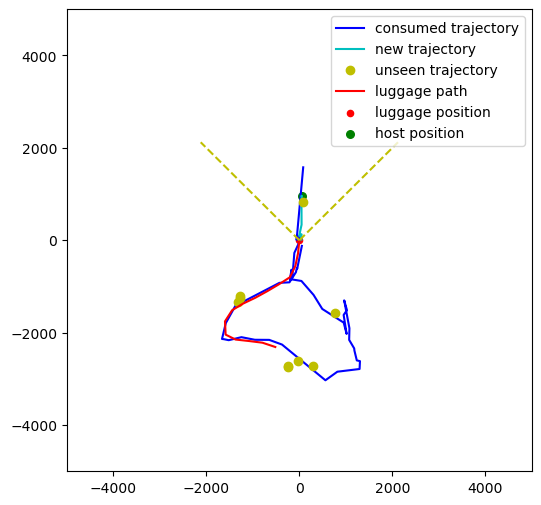

In [8]:
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


# constants
marching_rate = 0.8
follow_distance = 1220
sharp_distance = 915
follow_angle = 40
hhfov = 45


# variables
position = 0
index = 0
ratio = 0.0


def move(position, marching_rate):
    position += marching_rate
    index = int(position)
    return position, index, position - index


def consume(seen_s, rotated):
    # luggage position is 0,0
    for i in range(1, len(seen_s)):
        previous = seen_s.iloc[i-1]
        current = rotated.iloc[i]
        if previous['c'] == 1 and current['x'] <= 0:
            seen_s['c'][i] = 1


def get_s_data(s_data, seen_s, l_p, angle, index):
    last_seen = seen_s.iloc[-1]
    if index >= len(s_data):
        return last_seen, 0
    
    new_pt = s_data.iloc[index]
    pt = Point.from_df(new_pt)
    pt = l_p.rotates(-angle, pt, recenter=True)
    angle = Point.origin().angle(pt)
    if abs(angle) > hhfov:
        return last_seen, angle
    return new_pt, 0


# sensor data
s_data = pd.read_csv('dist_2fps.csv', header=None)
s_data.columns = ['t', 'x', 'y']

# luggage data
l_data = pd.read_csv('sampled_positions.csv', header=None)
l_data.columns = ['x', 'y']

# luggage path
l_path = pd.DataFrame(columns=['x', 'y'])

# dataframe to store the seen points time, x, y, consumed
seen_s = pd.DataFrame(columns=['t', 'x', 'y', 'c'])
seen_s = pd.concat([seen_s, pd.DataFrame({
    't': 0,
    'x': 0,
    'y': 0,
    'c': 1
}, index=[len(seen_s)])])

unseen_s = pd.DataFrame(columns=['t', 'x', 'y'])

# image each loop is 0.5 second
for i in range(len(s_data['x']) + 5):
    clear_output(wait=True)

    # current luggage position
    l1 = Point.from_df(l_data.iloc[index])
    l2 = Point.from_df(l_data.iloc[index + 1])
    luggage = l1.between(l2, ratio)
    l_path = pd.concat([l_path, pd.DataFrame({
        'x': [luggage.x],
        'y': [luggage.y]
    }, index=[len(l_path)])])
    angle = l1.angle(l2)

    # current real human position
    human = Point.from_df(s_data.iloc[min(i, len(s_data) - 1)])

    # get sensor data
    new_seen, is_out = get_s_data(s_data, seen_s, luggage, angle, i)
    last_seen = Point.from_df(new_seen)
    seen_s = pd.concat([seen_s, pd.DataFrame({
        't': [new_seen['t']],
        'x': [new_seen['x']],
        'y': [new_seen['y']], 
        'c': 0
    }, index=[len(seen_s)])])

    if is_out:
        unseen_pt = s_data.iloc[i]
        unseen_s = pd.concat([unseen_s, pd.DataFrame({
            't': [unseen_pt['t']],
            'x': [unseen_pt['x']],
            'y': [unseen_pt['y']], 
        }, index=[len(unseen_s)])])

    # transform
    rot_unseen = luggage.rotate_df(angle, unseen_s)
    rotated = luggage.rotate_df(angle, seen_s)
    path_rot = luggage.rotate_df(angle, l_path)
    human = luggage.rotates(-angle, human, recenter=True)
    luggage = Point.origin()

    # consume trajectory
    consume(seen_s, rotated)
    rotated['c'] = seen_s['c']
    
    # plot properties
    fig, ax = plt.subplots()
    ax.set_ylim([-5000, 5000])
    ax.set_xlim([-5000, 5000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    # plot trajectory
    rot_consume = rotated[rotated['c'] == True]
    rot_not_consume = rotated[rotated['c'] == False]
    rot_not_consume = pd.concat([rot_consume.iloc[-1], rot_not_consume])

    ax.plot(rot_consume['y'], rot_consume['x'], color='b', label='consumed trajectory')
    ax.plot(rot_not_consume['y'], rot_not_consume['x'], color='c', label='new trajectory')
    ax.plot(rot_unseen['y'], rot_unseen['x'], 'o', color='y', label='unseen trajectory')

    # plot luggage position
    path_trail_len = min(35, len(path_rot))
    path_rot = path_rot.iloc[-path_trail_len:]
    ax.plot(path_rot['y'], path_rot['x'], color='r', label='luggage path')
    luggage.scatter(ax, color='r', size=20, label='luggage position')
    luggage.plot(ax, color='y', fov=hhfov*2, fov_len=3000)

    # plot human position
    human.scatter(ax, color='g', size=30, label='host position')

    ax.legend()
    plt.show()
    plt.pause(0.1)

    # move luggage to next point
    last_seen = Point.from_df(rotated.iloc[-1])
    distance = luggage.distance(last_seen)
    angle = (luggage.angle(last_seen))
    if is_out or distance > follow_distance or (distance > sharp_distance and abs(angle) > follow_angle):
        position, index, ratio = move(position, marching_rate)



## Moving Vehicule Example

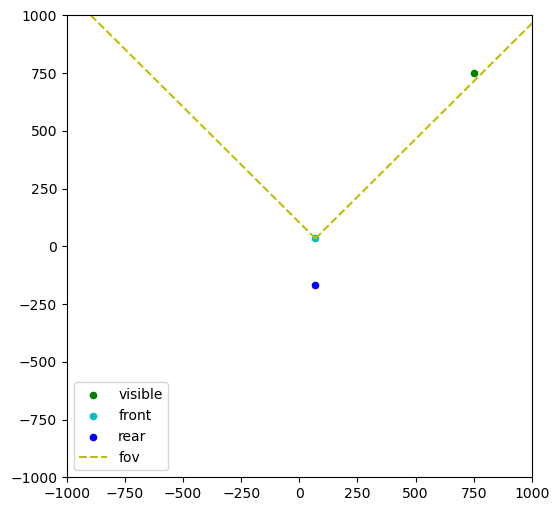

In [9]:
from src.vehicule import Vehicule

vehicule = Vehicule(max_turn_angle=30, axle_len=200, max_speed=2000, center=Point(0, 0))
speed, wheel_angle = 100, 0

# set_speed(speed) in mm/s
# set_wheel_angle(angle) in degrees
# update_position(time) in seconds
pt = Point(750, 750)

for i in range(42):

    if i >= 2:
        wheel_angle = 30

    if i >= 22:
        wheel_angle = -30

    vehicule.set_speed(speed)
    vehicule.set_wheel_angle(wheel_angle)
    vehicule.update_position(1)

    clear_output(wait=True)

    # plot properties
    fig, ax = plt.subplots()
    ax.set_ylim([-1000, 1000])
    ax.set_xlim([-1000, 1000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    if pt.is_visible(vehicule.get_front(), fov=vehicule.fov):
        pt.scatter(ax, color='g', size=20, label='visible')
    else:
        pt.scatter(ax, color='r', size=20, label='not visible')

    vehicule.front.scatter(ax, color='c', size=20, label='front')
    vehicule.rear.scatter(ax, color='b', size=20, label='rear')
    fov = vehicule.front.copy()
    fov.a = np.rad2deg(vehicule.north_angle)
    # black line from rear to front

    # plot line from rear to front
    fov.plot(ax, color='y', fov=90, fov_len=2000, linestyle='--', label='fov')

    ax.legend()
    plt.show()
    plt.pause(0.05)


## Vehicule following last known position
Here we have a robot using a wheel system comparable to the actual robot. This will be used to create the actual movement decision of the robot such as speed and angle of the wheels. This version has the only goal to reach the last seen position of the host and fails to track the entire trajectory of the host. The above approach using the spline is to be utilized. 

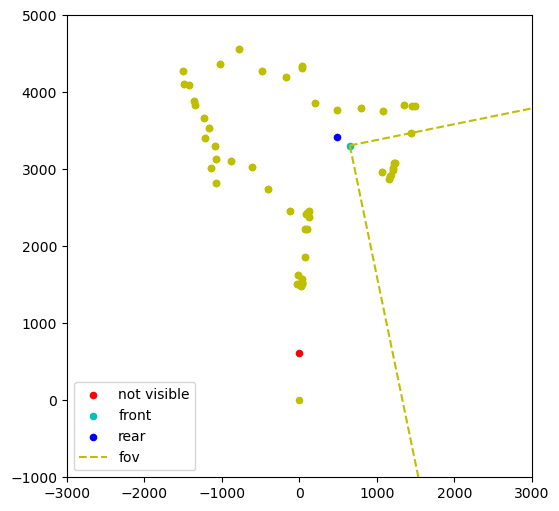

In [8]:
from src.vehicule import Vehicule

vehicule = Vehicule(max_turn_angle=30, axle_len=200, max_speed=2000, center=Point(0, 0))

# sensor data (secret - vehicle sees through sense_position)
s_data = pd.read_csv('dist_2fps.csv', header=None)
s_data.columns = ['t', 'x', 'y']

def sense_position(vehicle, s_data, index):
    if index >= len(s_data):
        return None
    new_pt = Point.from_df(s_data.iloc[index])
    if new_pt.is_visible(vehicle.get_front(), fov=vehicle.fov):
        return new_pt
    else:
        return None

# luggage data
seen = pd.DataFrame(columns=['t', 'x', 'y', 'c'])
seen = pd.concat([seen, pd.DataFrame({
    't': 0, # timestamp
    'x': 0, # x position
    'y': 0, # y position
    'c': 1, # consumed
}, index=[len(seen)])])


speed, wheel_angle = 100, 0

# set_speed(speed) in mm/s
# set_wheel_angle(angle) in degrees
# update_position(time) in seconds

for i in range(len(s_data['x'])*2 + 20):
    clear_output(wait=True)
    index = i // 2

    # to have smoother video
    if i % 2 == 1:
        vehicule.update_position(0.25)

    new_seen = sense_position(vehicule, s_data, index)
    if new_seen is not None:
        seen = pd.concat([seen, pd.DataFrame({
            't': [index],
            'x': [new_seen.x],
            'y': [new_seen.y], 
            'c': 0
        }, index=[len(seen)])])

    last_point = Point.from_df(seen.iloc[-1])
    if new_seen is not None:
        last_seen = new_seen
    if vehicule.can_move(last_point, new_seen):
        vehicule.set_speed(vehicule.distance_to_point(last_point) // 4)
        vehicule.set_wheel_angle(vehicule.angle_to_point(last_point))
        vehicule.update_position(0.25)
    else:
        vehicule.stop()

    # print(f'{speed} mm/s')
    # print(f'{angle} deg')

    # plot properties
    fig, ax = plt.subplots()
    ax.set_ylim([-1000, 5000])
    ax.set_xlim([-3000, 3000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    for x in range(len(seen)):
        Point.from_df(seen.iloc[x]).scatter(ax, color='y', size=20)

    host_position = Point.from_df(s_data.iloc[min(index, len(s_data) - 1)])
    if host_position.is_visible(vehicule.get_front(), fov=vehicule.fov):
        host_position.scatter(ax, color='g', size=20, label='visible')
    # elif vehicule.has_lost_track(host_position):
    #     vehicule.look_around()
    #     vehicule.continue_moving()
    #     ...
    else:
        host_position.scatter(ax, color='r', size=20, label='not visible')

    # method vehicule has lost the host - time from last know position - look around

    vehicule.front.scatter(ax, color='c', size=20, label='front')
    vehicule.rear.scatter(ax, color='b', size=20, label='rear')
    fov = vehicule.front.copy()
    fov.a = np.rad2deg(vehicule.north_angle)
    # black line from rear to front

    # plot line from rear to front
    fov.plot(ax, color='y', fov=90, fov_len=20000, linestyle='--', label='fov')

    ax.legend()
    plt.show()
    # plt.pause(0.01)



## Future developpement
We need a way to identify the host reliably. Many ReID technologies exists and need to be explored and tested to find one that is able to lock on the host. 